In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [45]:
!pip install np_utils

# LIB IMPORT

In [46]:
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
import np_utils
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# SETTING CONSTANTS

In [47]:
TRAIN_IMG = "/kaggle/input/melanoma-cancer-dataset/train"
TEST_IMG = "/kaggle/input/melanoma-cancer-dataset/test"
N_CLASS = 2
BATCH = 32
ROWS = 224
COLS = 224
SHAPE = (ROWS, COLS, 3)
EPOCHS = 15
TRAIN_SAMPLES = 3000
TEST_SAMPLES = 3000

# PREPROCESS

In [48]:
train_gen = ImageDataGenerator(rescale=1/.255).flow_from_directory(directory=TRAIN_IMG,
                                                                 class_mode='categorical',
                                                                 batch_size=BATCH,
                                                                 target_size=(ROWS, COLS),
                                                                 color_mode='rgb',
                                                                 shuffle=True)
test_gen = ImageDataGenerator(rescale=1/.255).flow_from_directory(directory=TEST_IMG,
                                                                 class_mode='categorical',
                                                                 batch_size=BATCH,
                                                                 target_size=(ROWS, COLS),
                                                                 color_mode='rgb',
                                                                 shuffle=False)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# BUILDING CNN MODEL

In [59]:
from keras.optimizers import Adam

def CNN(layers = 3, filters = 32, filters_size = (3, 3), init = 'glorot_uniform', active_func = 'relu', opt='RMSprop'):
    
    model = Sequential()
    for i in range(0, layers):
        model.add(Conv2D(filters, filters_size, activation=active_func, input_shape=SHAPE))
        model.add(MaxPooling2D(2, 2))
#         model.add(Dropout(do))
    
    model.add(Flatten())
    model.add(Dense(512, activation=active_func))
    model.add(Dense(N_CLASS, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model


# Add Confusion Matrix

In [49]:
import matplotlib.pyplot as plt
import itertools

def Evaluate(confusion, class_names, normalize=True, title="Evaluation", cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(confusion, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tm = np.arange(len(class_names))
    plt.xticks(tm, class_names, rotation=45)
    plt.yticks(tm, class_names)
    
    if normalize:
        confusion = confusion.astype('float')/confusion.sum(axis=1)[:, np.newaxis]
        confusion = np.around(confusion, decimals=2)
        confusion[np.isnan(confusion)] = 0.0
        print("normal ConfMatrix")
    else:
        print("no normal ConfMatrix")
    
    thresh = confusion.max()/2
    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, confusion[i, j],
                horizontalalignment='center',
                color='white' if confusion[i, j] > thresh else 'black'
                )
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()
    
    
    

In [54]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping

def trainAndEval(model, epoch):
    # early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history = model.fit(train_gen, epochs=epoch, steps_per_epoch=35, validation_data = test_gen, batch_size = 20)
    
    loss_and_metrics = model.evaluate(test_gen, steps=35)
    print("Loss: ", loss_and_metrics[0])
    print("Accuracy: ", loss_and_metrics[1])
    test_gen.reset()
    
    Y_pred = model.predict(test_gen, steps=TEST_SAMPLES // BATCH + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    
    class_names = []
    for key in train_gen.class_indices:
        class_names.append(key)
        
    cr = classification_report(test_gen.classes, y_pred, target_names=class_names)
    print("Class Report\n" + cr)
    confusion = confusion_matrix(test_gen.classes, y_pred)
    
    Evaluate(confusion, class_names, normalize=True, title='Evaluation')
    Evaluate(confusion, class_names, normalize=False, title='Evaluation')
    
    plot_history(history)
    
    return model

In [ ]:
# # 2nd best, w/o early stopping
# model = CNN(layers=3, filters=64, filters_size=(2,2), active_func='relu')
# model = trainAndEval(model, epoch=30)

# Other Trials
the models below is just for experiment purpose only

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 223, 223, 48)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 111, 111, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 110, 110, 48)   │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 55, 55, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 54, 54, 48)     │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 27, 27, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 34992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │    17,916,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,936,594 (68.42 MB)

 Trainable params: 17,936,594 (68.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/45
 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5226 - loss: 372.5546

W0000 00:00:1717562480.236035     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5216 - loss: 181.6525

W0000 00:00:1717562482.786138     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5233 - loss: 178.7509 - val_accuracy: 0.6340 - val_loss: 6.1545
Epoch 2/45
 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7891 - loss: 3.4002

W0000 00:00:1717562486.099375     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.7551 - loss: 3.4195 - val_accuracy: 0.6040 - val_loss: 5.3222
Epoch 3/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.6677 - loss: 5.7664 - val_accuracy: 0.7500 - val_loss: 1.4197
Epoch 4/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7626 - loss: 1.7779 - val_accuracy: 0.7525 - val_loss: 1.8894
Epoch 5/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7726 - loss: 2.2863 - val_accuracy: 0.6450 - val_loss: 4.5190
Epoch 6/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7323 - loss: 3.1368 - val_accuracy: 0.6710 - val_loss: 3.3746
Epoch 7/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7893 - loss: 1.5940 - val_accuracy: 0.7675 - val_loss: 1.0878
Epoch 8/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.7576 - loss: 1.6938 - val_accuracy: 0.6995 - val_loss: 2.1044
Epoch 9/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8069 - loss: 1.2280 - val_accuracy: 0.8200 - val_

W0000 00:00:1717562532.770006     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7798 - loss: 1.4546 - val_accuracy: 0.6795 - val_loss: 1.8689
Epoch 12/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7387 - loss: 1.8491 - val_accuracy: 0.7165 - val_loss: 1.7632
Epoch 13/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8197 - loss: 1.1449 - val_accuracy: 0.7765 - val_loss: 1.0126
Epoch 14/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7958 - loss: 1.1723 - val_accuracy: 0.7665 - val_loss: 1.3747
Epoch 15/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7376 - loss: 1.7688 - val_accuracy: 0.7495 - val_loss: 1.3085
Epoch 16/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8270 - loss: 1.1084 - val_accuracy: 0.7855 - val_loss: 0.9186
Epoch 17/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8456 - loss: 0.6540 - val_accuracy: 0.8365 - val_loss: 0.5107
Epoch 18/45
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8574 - loss: 0.5098 - val_accuracy: 0.8095

W0000 00:00:1717562709.768802     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


W0000 00:00:1717562712.932220     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Class Report
              precision    recall  f1-score   support

      Benign       0.81      0.90      0.86      1000
   Malignant       0.89      0.80      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

normal ConfMatrix


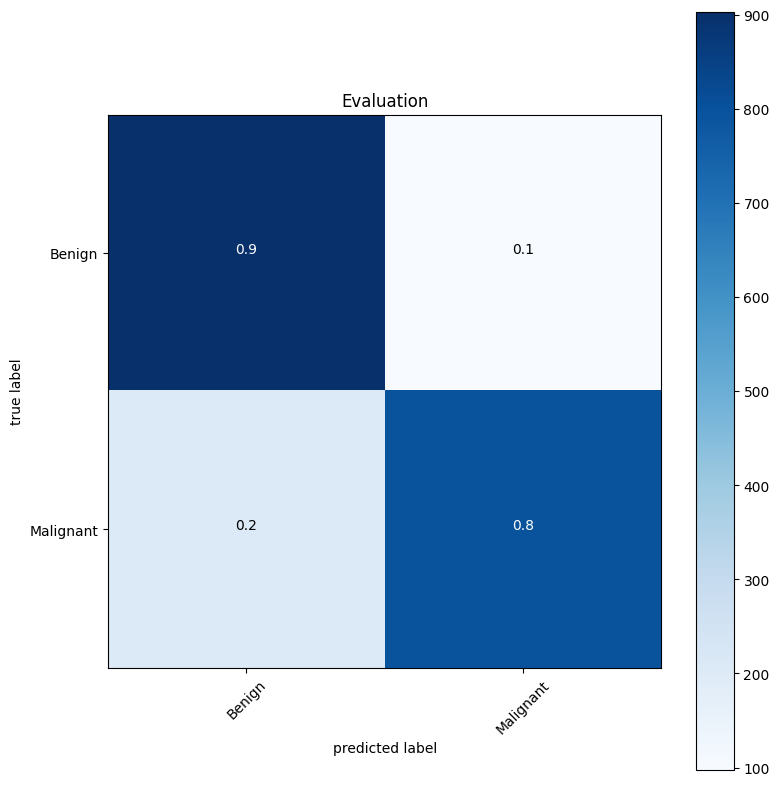

no normal ConfMatrix


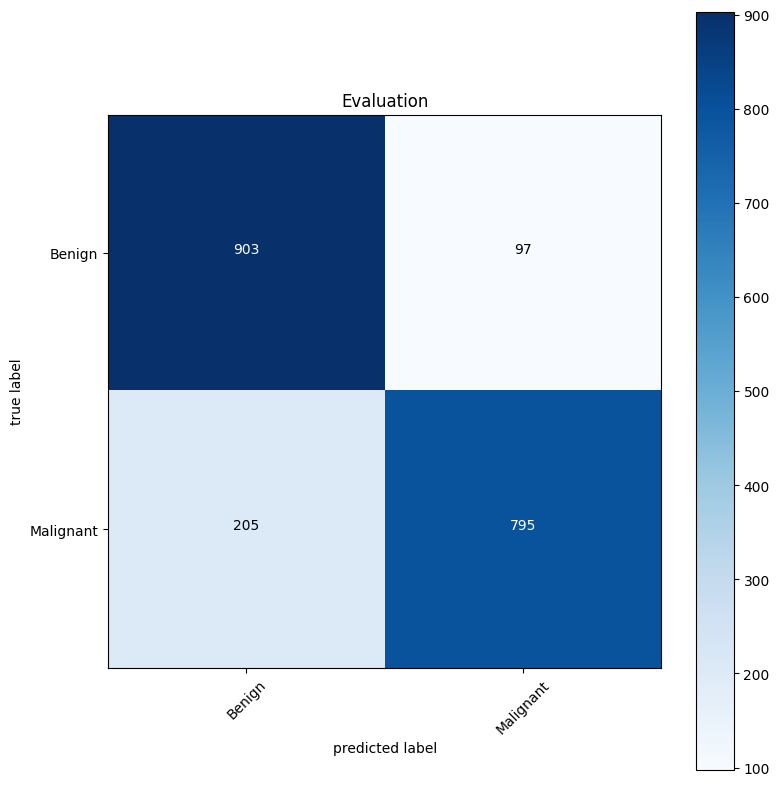

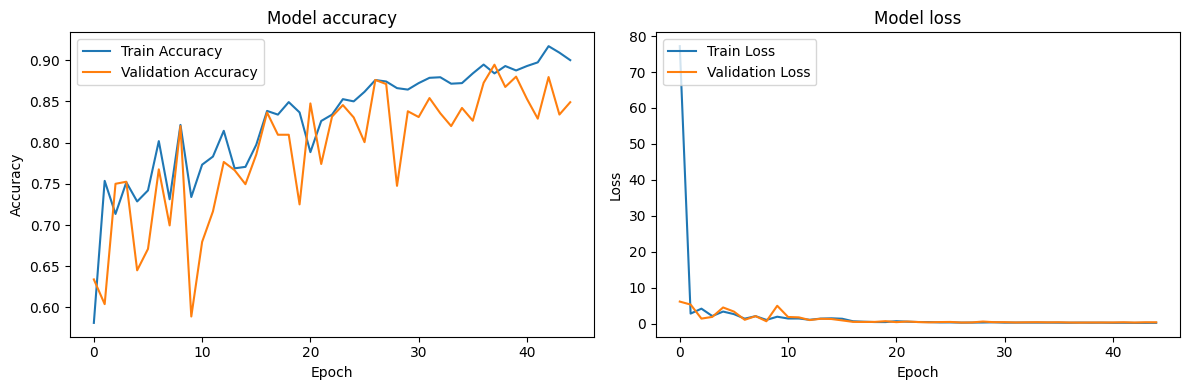

In [62]:
# on lead, current best model by 020624 at 14.24, wo early stopping

model = CNN(layers=3, filters=48, filters_size=(2,2), active_func='relu')
model = trainAndEval(model, epoch=45)


In [ ]:
# # 4th best model

# model = CNN(layers=3, filters=48, filters_size=(2,2), active_func='relu')
# model = trainAndEval(model, epoch=40)

In [ ]:
# # 3rd best model from previous, winning by recall and f score
# model = CNN(layers=3, filters=48, filters_size=(3,3), active_func='relu')
# model = trainAndEval(model, epoch=40)

In [ ]:
# model = CNN(layers=4, filters=48, filters_size=(1,1), active_func='relu')
# model = trainAndEval(model, epoch=40)